# Анализ данных футболистов FIFA 19 (поиск инсайтов, составление рекомендаций стейкхолдерам, построение предиктивной модели потенциала игроков)

<strike>Проверка гипотезы, что на основании текущего рейтинга и данных об игроке определить его возможный рейтинг в следующем сезоне.
Данная информация поможет скауту/спортивному директору определиться с выбором при покупке игрока/продлении с ним контракта.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Анализ данных

***

In [2]:
df_load = pd.read_csv('data.csv', delimiter=',')
df_load.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
print('Топ 5 стран по количеству игроков')
df_load['Nationality'].value_counts().head(5)

Топ 5 стран по количеству игроков


England      1662
Germany      1198
Spain        1072
Argentina     937
France        914
Name: Nationality, dtype: int64

Можно сделать вывод, что большинство игроков из стран Европы

In [4]:
print('Максимальный потенциал : '+str(df_load.loc[df_load['Potential'].idxmax()][2]))
print('Максимальный общий показатель : '+str(df_load.loc[df_load['Overall'].idxmax()][2]))

Максимальный потенциал : K. Mbappé
Максимальный общий показатель : L. Messi


In [5]:
pr_cols = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
print('Лучшие в различных аспектах игры :\n')
i = 0
my_list = []
while i < len(pr_cols):
    print('Лучший в {0} : {1}'.format(pr_cols[i],df_load.loc[df_load[pr_cols[i]].idxmax()][2]))
    my_list.append(df_load.loc[df_load[pr_cols[i]].idxmax()][2])
    i = i + 1

Лучшие в различных аспектах игры :

Лучший в Crossing : K. De Bruyne
Лучший в Finishing : L. Messi
Лучший в HeadingAccuracy : Naldo
Лучший в ShortPassing : L. Modrić
Лучший в Volleys : E. Cavani
Лучший в Dribbling : L. Messi
Лучший в Curve : Quaresma
Лучший в FKAccuracy : L. Messi
Лучший в LongPassing : T. Kroos
Лучший в BallControl : L. Messi
Лучший в Acceleration : Douglas Costa
Лучший в SprintSpeed : K. Mbappé
Лучший в Agility : Neymar Jr
Лучший в Reactions : Cristiano Ronaldo
Лучший в Balance : Bernard
Лучший в ShotPower : Cristiano Ronaldo
Лучший в Jumping : Cristiano Ronaldo
Лучший в Stamina : N. Kanté
Лучший в Strength : A. Akinfenwa
Лучший в LongShots : L. Messi
Лучший в Aggression : B. Pearson
Лучший в Interceptions : N. Kanté
Лучший в Positioning : Cristiano Ronaldo
Лучший в Vision : L. Messi
Лучший в Penalties : M. Balotelli
Лучший в Composure : L. Messi
Лучший в Marking : A. Barzagli
Лучший в StandingTackle : G. Chiellini
Лучший в SlidingTackle : Sergio Ramos
Лучший в GKDiv

In [6]:
cmn = collections.Counter(my_list).most_common() 
for i in range(3):
    print(str(cmn[i][0]) + ' встречается ' +str(cmn[i][1]) + ' раз(а) в списке')

L. Messi встречается 7 раз(а) в списке
Cristiano Ronaldo встречается 4 раз(а) в списке
N. Kanté встречается 2 раз(а) в списке


Зависимость потенциала игрока от его возраста

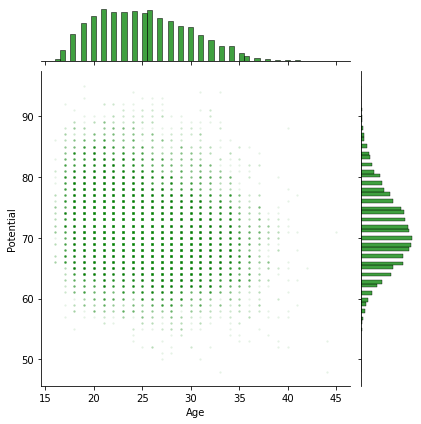

In [7]:
sns.jointplot(x=df_load['Age'],y=df_load['Potential'],
              joint_kws={'alpha':0.1,'s':5,'color':'green'},
              marginal_kws={'color':'green'})

Вывод: чем старше игрок, тем меньше потенциал 

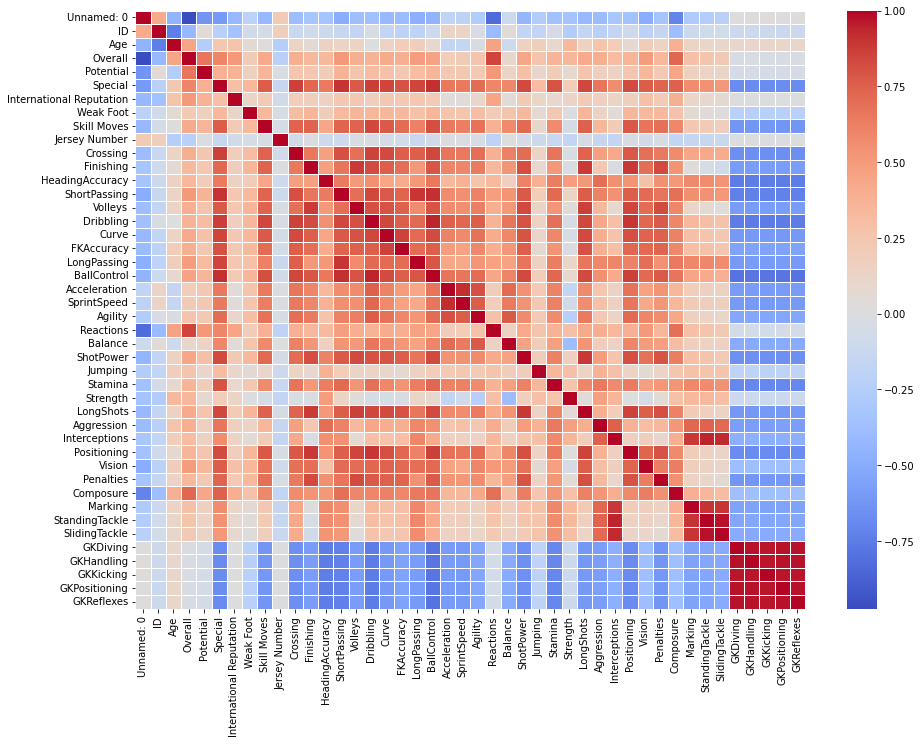

In [8]:
ax = plt.figure(figsize=(15, 11))
ax = sns.heatmap(df_load.corr(), linewidths=.5, cmap="coolwarm")

### Подготовка данных для

***

Удаляем не влияющие на футбольные качества игрока данные

In [9]:
drop_cols = df_load.columns[28:54]
df = df_load.drop(drop_cols, axis = 1)
df.drop(['Unnamed: 0',
         'Name',
         'Nationality',
         'Photo',
         'Flag',
         'Club Logo',
         'Club',
         'Real Face',
         'Height',
         'Weight',
         'Value',
         'Wage',
         'Loaned From',
         'Joined',
         'Jersey Number',
         'Release Clause',
         'Contract Valid Until',
         'Body Type'],axis=1,inplace=True)
df.head()

,ID,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,31,94,94,2202,Left,5.0,4.0,4.0,Medium/ Medium,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,33,94,94,2228,Right,5.0,4.0,5.0,High/ Low,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,26,92,93,2143,Right,5.0,5.0,5.0,High/ Medium,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,27,91,93,1471,Right,4.0,3.0,1.0,Medium/ Medium,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,27,91,92,2281,Right,4.0,5.0,4.0,High/ High,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18207 non-null  int64  
 1   Age                       18207 non-null  int64  
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Special                   18207 non-null  int64  
 5   Preferred Foot            18159 non-null  object 
 6   International Reputation  18159 non-null  float64
 7   Weak Foot                 18159 non-null  float64
 8   Skill Moves               18159 non-null  float64
 9   Work Rate                 18159 non-null  object 
 10  Position                  18147 non-null  object 
 11  Crossing                  18159 non-null  float64
 12  Finishing                 18159 non-null  float64
 13  HeadingAccuracy           18159 non-null  float64
 14  ShortP

#### Проверяем пустые значения

In [11]:
df[df['Preferred Foot'].isnull()]

,ID,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
13236,177971,33,62,62,1510,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13237,195380,29,62,62,1532,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13238,139317,35,62,62,1573,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13239,240437,20,62,72,1610,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13240,209462,24,62,66,1481,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13241,219702,21,62,72,1692,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13242,225590,23,62,70,1663,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13243,233782,19,62,78,1328,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13244,239158,30,62,62,1244,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13245,242998,21,62,69,1549,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Можно эти строки удалить

In [12]:
df.drop(df[df['Preferred Foot'].isnull()].index.tolist(),inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18159 non-null  int64  
 1   Age                       18159 non-null  int64  
 2   Overall                   18159 non-null  int64  
 3   Potential                 18159 non-null  int64  
 4   Special                   18159 non-null  int64  
 5   Preferred Foot            18159 non-null  object 
 6   International Reputation  18159 non-null  float64
 7   Weak Foot                 18159 non-null  float64
 8   Skill Moves               18159 non-null  float64
 9   Work Rate                 18159 non-null  object 
 10  Position                  18147 non-null  object 
 11  Crossing                  18159 non-null  float64
 12  Finishing                 18159 non-null  float64
 13  HeadingAccuracy           18159 non-null  float64
 14  ShortP

В датасете осталось 12 строк с пустыми значениям в поле Position

In [13]:
df[df['Position'].isnull()]

,ID,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
5018,153160,37,70,70,1574,Right,1.0,3.0,2.0,Medium/ Medium,...,77.0,64.0,79.0,70.0,70.0,16.0,8.0,11.0,12.0,13.0
6736,175393,33,68,68,1664,Left,1.0,3.0,3.0,High/ Low,...,69.0,67.0,12.0,34.0,33.0,16.0,13.0,15.0,16.0,8.0
7922,195905,33,67,67,1619,Right,1.0,3.0,2.0,Medium/ Medium,...,42.0,54.0,72.0,71.0,64.0,11.0,7.0,8.0,12.0,12.0
9905,226044,23,66,69,1632,Right,1.0,4.0,3.0,High/ Low,...,67.0,64.0,19.0,24.0,23.0,13.0,11.0,11.0,7.0,9.0
10628,216751,26,65,66,1536,Right,1.0,2.0,2.0,Medium/ Medium,...,39.0,57.0,68.0,69.0,68.0,14.0,12.0,11.0,14.0,12.0
16450,193911,31,57,57,1032,Right,1.0,3.0,1.0,Medium/ Medium,...,16.0,52.0,12.0,15.0,12.0,53.0,48.0,62.0,57.0,60.0
16539,245167,23,57,63,1410,Left,1.0,4.0,2.0,High/ Medium,...,38.0,57.0,60.0,61.0,57.0,15.0,12.0,11.0,6.0,12.0
16793,228192,31,56,56,1613,Right,1.0,3.0,2.0,Medium/ Medium,...,59.0,63.0,43.0,48.0,32.0,7.0,8.0,9.0,15.0,9.0
17129,228198,26,55,58,1466,Right,1.0,4.0,2.0,High/ Medium,...,65.0,42.0,26.0,18.0,13.0,15.0,14.0,8.0,10.0,16.0
17339,233526,23,54,63,1321,Right,1.0,3.0,2.0,Medium/ Low,...,58.0,45.0,14.0,23.0,21.0,8.0,6.0,13.0,9.0,10.0


Что является незначительной частью от общего количества - поэтому удаляем эти строки

In [14]:
df.dropna(inplace=True)
df

,ID,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,31,94,94,2202,Left,5.0,4.0,4.0,Medium/ Medium,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,33,94,94,2228,Right,5.0,4.0,5.0,High/ Low,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,26,92,93,2143,Right,5.0,5.0,5.0,High/ Medium,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,27,91,93,1471,Right,4.0,3.0,1.0,Medium/ Medium,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,27,91,92,2281,Right,4.0,5.0,4.0,High/ High,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,238813,19,47,65,1307,Right,1.0,2.0,2.0,Medium/ Medium,...,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,243165,19,47,63,1098,Right,1.0,2.0,2.0,Medium/ Medium,...,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,241638,16,47,67,1189,Right,1.0,3.0,2.0,Medium/ Medium,...,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,246268,17,47,66,1228,Right,1.0,3.0,2.0,Medium/ Medium,...,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [15]:
def right_footed(df):
    if (df['Preferred Foot'] == 'Right'):
        return 1
    else:
        return 0

def simple_position(df):
    if (df['Position'] == 'GK'):
        return '0'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return '1'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return '2'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')):
        return '3'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return '4'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return '5'
    else:
        return df.Position

def work_rate(df):
    if (df['WorkRate1'] == 'High'):
        return 2
    if (df['WorkRate1'] == 'Medium'):
        return 1    
    else:
        return 0    

def work_rate2(df):
    if (df['WorkRate2'] == 'High'):
        return 2
    if (df['WorkRate2'] == 'Medium'):
        return 1    
    else:
        return 0    
    

df_new = df.copy()


df_new['Right_Foot'] = df_new.apply(right_footed, axis=1)
df_new['Simple_Position'] = df_new.apply(simple_position,axis = 1)


tempwork = df_new['Work Rate'].str.split("/ ", n = 1, expand = True) 

df_new['WorkRate1']= tempwork[0]
df_new['WorkRate_1'] = df_new.apply(work_rate, axis=1)

df_new['WorkRate2']= tempwork[1]
df_new['WorkRate_2'] = df_new.apply(work_rate2, axis=1)


df_new = df_new.drop(['Work Rate','WorkRate1','WorkRate2','Preferred Foot', 'Position'], axis = 1)
df_new.head().T

,0,1,2,3,4
ID,158023,20801,190871,193080,192985
Age,31,33,26,27,27
Overall,94,94,92,91,91
Potential,94,94,93,93,92
Special,2202,2228,2143,1471,2281
International Reputation,5.0,5.0,5.0,4.0,4.0
Weak Foot,4.0,4.0,5.0,3.0,5.0
Skill Moves,4.0,5.0,5.0,1.0,4.0
Crossing,84.0,84.0,79.0,17.0,93.0
Finishing,95.0,94.0,87.0,13.0,82.0


In [16]:
model = LinearRegression()

In [17]:
y = df_new['Potential']
X = df_new.drop(['Potential'], axis = 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [19]:
model.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = model.predict(X_test)
y_pred

array([72.52045379, 73.46293346, 71.52664486, ..., 70.78900722,
       72.56781615, 69.00982578])

In [21]:
print('score : '+str(model.score(X_test, y_test)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, y_pred))))

score : 0.8444197017607007
RMSE : 2.4263599664352937


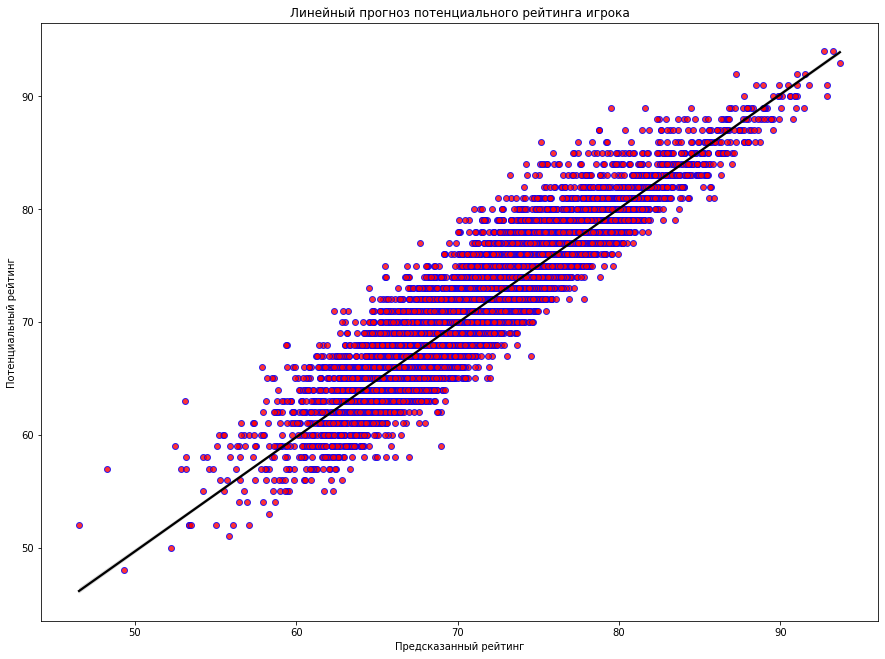

In [22]:
plt.figure(figsize=(15,11))
sns.regplot(x = y_pred,y = y_test, scatter_kws={'color':'red','edgecolor':'blue'},line_kws={'color':'black'})
plt.xlabel('Предсказанный рейтинг')
plt.ylabel('Потенциальный рейтинг')
plt.title('Линейный прогноз потенциального рейтинга игрока')
plt.show()